In [1]:
import time
import numpy as np
import pandas as pd
import os
import random

In [2]:
import tensorflow.python.keras as keras
from tensorflow.python.keras.layers import Layer
import tensorflow as tf
import dan_models
import dan_utils

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
randseed = random.randint(0, 1000)
dan_utils.setup_seed(randseed)

In [4]:
class_set = [2, 3, 4]
res = 11

v, v_class, id_402, part1, part2, seg, det_list_class, near_road_set  \
        = dan_utils.load_data(class_set, res, randseed=25)

There are 5 class(es)


C:\Users\10169\anaconda3\envs\dan_traff\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [5]:
# ind, class
# 0  , blue
# 1  , green
# 2  , yellow  <--
# 3  , black   <--
# 4  , red     <--
class_color_set = ['b', 'g', 'y', 'black', 'r']
class_i = 2

near_road = np.array(near_road_set[class_i])
# flow = v_class[class_i].iloc[:, 2:-1]
flow = pd.read_csv('../data/flow_r_revised.csv')

prop = 0.2  # proportion of training data
from_day = 22
to_day = 31
num_links = v_class[class_i].shape[0]

image_train, image_test, day_train, day_test, label_train, label_test\
= dan_utils.sliding_window(
    flow, near_road, from_day, to_day, prop, num_links
)

t_input = image_train.shape[2]
t_pre = label_train.shape[2]
k = image_train.shape[1]

(1008, 5, 12, 40)
(201, 5, 12, 40)
(807, 5, 12, 40)
(201, 40, 6)
(807, 40, 6)


In [6]:
input_data = keras.Input(shape=(k,t_input,num_links), name='input_data')
input_HA = keras.Input(shape=(num_links, t_pre), name='input_HA')

finish_model = dan_models.build_model(input_data, input_HA)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         [(None, 5, 12, 40)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 5, 12, 40)    160         input_data[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 5, 12, 40)    14440       batch_normalization[0][0]        
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 5, 12, 40)    0           conv2d[0][0]                     
______________________________________________________________________________________________

In [7]:
finish_model.compile(optimizer='adam', loss='mean_squared_error')

In [8]:
X_train = image_train
X_HA_train = day_train
label_train = label_train

In [9]:
#模型拟合与评估
finish_model.fit([X_train,X_HA_train], label_train, epochs=1500, batch_size=2048,
validation_data=([image_test,day_test], label_test))
# finish_model.evaluate(image_test, label_test)

Epoch 1/1500
1/1 [==============================] - 5s 5s/step - loss: 299519.7500 - val_loss: 282868.9062
Epoch 2/1500
1/1 [==============================] - 0s 45ms/step - loss: 298923.7500 - val_loss: 282218.7188
Epoch 3/1500
1/1 [==============================] - 0s 38ms/step - loss: 298324.4375 - val_loss: 281524.3438
Epoch 4/1500
1/1 [==============================] - 0s 41ms/step - loss: 297719.4688 - val_loss: 280764.2500
Epoch 5/1500
1/1 [==============================] - 0s 41ms/step - loss: 297107.5938 - val_loss: 279908.0625
Epoch 6/1500
1/1 [==============================] - 0s 41ms/step - loss: 296485.1875 - val_loss: 278914.6250
Epoch 7/1500
1/1 [==============================] - 0s 42ms/step - loss: 295851.5312 - val_loss: 277736.7188
Epoch 8/1500
1/1 [==============================] - 0s 41ms/step - loss: 295204.0938 - val_loss: 276324.9062
Epoch 9/1500
1/1 [==============================] - 0s 42ms/step - loss: 294539.0938 - val_loss: 274624.8125
Epoch 10/1500
1/1 [==

1/1 [==============================] - 0s 41ms/step - loss: 139426.0312 - val_loss: 189557.6562
Epoch 76/1500
1/1 [==============================] - 0s 40ms/step - loss: 138639.0938 - val_loss: 176488.5000
Epoch 77/1500
1/1 [==============================] - 0s 40ms/step - loss: 137801.4375 - val_loss: 166300.1094
Epoch 78/1500
1/1 [==============================] - 0s 40ms/step - loss: 137296.3594 - val_loss: 175361.0156
Epoch 79/1500
1/1 [==============================] - 0s 43ms/step - loss: 136354.7344 - val_loss: 161647.0156
Epoch 80/1500
1/1 [==============================] - 0s 42ms/step - loss: 135761.1250 - val_loss: 167252.1094
Epoch 81/1500
1/1 [==============================] - 0s 44ms/step - loss: 135018.7969 - val_loss: 172831.5312
Epoch 82/1500
1/1 [==============================] - 0s 41ms/step - loss: 134639.0469 - val_loss: 165511.8125
Epoch 83/1500
1/1 [==============================] - 0s 40ms/step - loss: 133789.6406 - val_loss: 160993.4219
Epoch 84/1500
1/1 [=====

1/1 [==============================] - 0s 41ms/step - loss: 114727.9766 - val_loss: 135005.7969
Epoch 150/1500
1/1 [==============================] - 0s 41ms/step - loss: 114504.1953 - val_loss: 134999.5156
Epoch 151/1500
1/1 [==============================] - 0s 41ms/step - loss: 114277.2109 - val_loss: 134862.6875
Epoch 152/1500
1/1 [==============================] - 0s 41ms/step - loss: 114101.4453 - val_loss: 135180.2188
Epoch 153/1500
1/1 [==============================] - 0s 41ms/step - loss: 113793.4609 - val_loss: 134934.4531
Epoch 154/1500
1/1 [==============================] - 0s 41ms/step - loss: 113654.9062 - val_loss: 134125.1562
Epoch 155/1500
1/1 [==============================] - 0s 37ms/step - loss: 113335.8203 - val_loss: 133512.8906
Epoch 156/1500
1/1 [==============================] - 0s 41ms/step - loss: 113119.5859 - val_loss: 133310.6719
Epoch 157/1500
1/1 [==============================] - 0s 41ms/step - loss: 112937.3203 - val_loss: 133448.0469
Epoch 158/1500
1

Epoch 223/1500
1/1 [==============================] - 0s 41ms/step - loss: 98913.9609 - val_loss: 121173.3594
Epoch 224/1500
1/1 [==============================] - 0s 40ms/step - loss: 98719.1016 - val_loss: 120382.8516
Epoch 225/1500
1/1 [==============================] - 0s 42ms/step - loss: 98477.5156 - val_loss: 120334.1172
Epoch 226/1500
1/1 [==============================] - 0s 42ms/step - loss: 98352.1406 - val_loss: 120993.6094
Epoch 227/1500
1/1 [==============================] - 0s 41ms/step - loss: 98103.1406 - val_loss: 120723.9219
Epoch 228/1500
1/1 [==============================] - 0s 41ms/step - loss: 97887.6484 - val_loss: 119929.1328
Epoch 229/1500
1/1 [==============================] - 0s 42ms/step - loss: 97703.7031 - val_loss: 119574.4141
Epoch 230/1500
1/1 [==============================] - 0s 40ms/step - loss: 97530.5469 - val_loss: 119699.3828
Epoch 231/1500
1/1 [==============================] - 0s 40ms/step - loss: 97316.2500 - val_loss: 119169.4609
Epoch 232/

1/1 [==============================] - 0s 41ms/step - loss: 85008.1875 - val_loss: 107139.8359
Epoch 298/1500
1/1 [==============================] - 0s 41ms/step - loss: 84830.9219 - val_loss: 107067.2188
Epoch 299/1500
1/1 [==============================] - 0s 40ms/step - loss: 84652.8594 - val_loss: 106314.7344
Epoch 300/1500
1/1 [==============================] - 0s 40ms/step - loss: 84488.2500 - val_loss: 105648.7500
Epoch 301/1500
1/1 [==============================] - 0s 40ms/step - loss: 84407.4688 - val_loss: 106007.3984
Epoch 302/1500
1/1 [==============================] - 0s 38ms/step - loss: 84089.2109 - val_loss: 106174.2266
Epoch 303/1500
1/1 [==============================] - 0s 41ms/step - loss: 83998.7969 - val_loss: 105536.6406
Epoch 304/1500
1/1 [==============================] - 0s 40ms/step - loss: 83783.2500 - val_loss: 105022.1953
Epoch 305/1500
1/1 [==============================] - 0s 37ms/step - loss: 83671.7578 - val_loss: 105144.2891
Epoch 306/1500
1/1 [=====

Epoch 372/1500
1/1 [==============================] - 0s 42ms/step - loss: 71945.5391 - val_loss: 92325.6641
Epoch 373/1500
1/1 [==============================] - 0s 41ms/step - loss: 71787.7344 - val_loss: 92534.7500
Epoch 374/1500
1/1 [==============================] - 0s 42ms/step - loss: 71653.9375 - val_loss: 92484.5078
Epoch 375/1500
1/1 [==============================] - 0s 41ms/step - loss: 71481.5234 - val_loss: 92140.0781
Epoch 376/1500
1/1 [==============================] - 0s 41ms/step - loss: 71318.6797 - val_loss: 91596.4844
Epoch 377/1500
1/1 [==============================] - 0s 40ms/step - loss: 71194.7109 - val_loss: 90918.5000
Epoch 378/1500
1/1 [==============================] - 0s 40ms/step - loss: 71051.4609 - val_loss: 90389.5156
Epoch 379/1500
1/1 [==============================] - 0s 42ms/step - loss: 70816.9062 - val_loss: 89972.7812
Epoch 380/1500
1/1 [==============================] - 0s 41ms/step - loss: 70716.4531 - val_loss: 89736.2812
Epoch 381/1500
1/1 

1/1 [==============================] - 0s 41ms/step - loss: 60844.5508 - val_loss: 77642.8359
Epoch 448/1500
1/1 [==============================] - 0s 38ms/step - loss: 60705.6016 - val_loss: 77194.4219
Epoch 449/1500
1/1 [==============================] - 0s 42ms/step - loss: 60579.3867 - val_loss: 77246.2422
Epoch 450/1500
1/1 [==============================] - 0s 44ms/step - loss: 60443.3750 - val_loss: 77334.6250
Epoch 451/1500
1/1 [==============================] - 0s 42ms/step - loss: 60340.6055 - val_loss: 76844.6016
Epoch 452/1500
1/1 [==============================] - 0s 41ms/step - loss: 60160.9766 - val_loss: 76472.9297
Epoch 453/1500
1/1 [==============================] - 0s 37ms/step - loss: 60076.5391 - val_loss: 76497.4375
Epoch 454/1500
1/1 [==============================] - 0s 39ms/step - loss: 59913.7578 - val_loss: 76652.1094
Epoch 455/1500
1/1 [==============================] - 0s 41ms/step - loss: 59817.2969 - val_loss: 76324.3984
Epoch 456/1500
1/1 [==============

1/1 [==============================] - 0s 41ms/step - loss: 51473.3516 - val_loss: 65840.4141
Epoch 523/1500
1/1 [==============================] - 0s 41ms/step - loss: 51312.9219 - val_loss: 66029.6875
Epoch 524/1500
1/1 [==============================] - 0s 40ms/step - loss: 51193.9258 - val_loss: 66003.4609
Epoch 525/1500
1/1 [==============================] - 0s 41ms/step - loss: 51120.3672 - val_loss: 65489.7578
Epoch 526/1500
1/1 [==============================] - 0s 41ms/step - loss: 50977.6484 - val_loss: 65359.1328
Epoch 527/1500
1/1 [==============================] - 0s 40ms/step - loss: 50853.6328 - val_loss: 65702.1328
Epoch 528/1500
1/1 [==============================] - 0s 40ms/step - loss: 50734.6719 - val_loss: 65573.7578
Epoch 529/1500
1/1 [==============================] - 0s 40ms/step - loss: 50632.4766 - val_loss: 64925.5859
Epoch 530/1500
1/1 [==============================] - 0s 42ms/step - loss: 50555.0664 - val_loss: 64897.8320
Epoch 531/1500
1/1 [==============

1/1 [==============================] - 0s 40ms/step - loss: 42864.3828 - val_loss: 58924.0703
Epoch 598/1500
1/1 [==============================] - 0s 40ms/step - loss: 42780.0508 - val_loss: 59139.2227
Epoch 599/1500
1/1 [==============================] - 0s 40ms/step - loss: 42613.9219 - val_loss: 59955.5078
Epoch 600/1500
1/1 [==============================] - 0s 40ms/step - loss: 42618.9023 - val_loss: 59378.5000
Epoch 601/1500
1/1 [==============================] - 0s 41ms/step - loss: 42390.3203 - val_loss: 59179.8828
Epoch 602/1500
1/1 [==============================] - 0s 41ms/step - loss: 42382.4844 - val_loss: 59806.1797
Epoch 603/1500
1/1 [==============================] - 0s 40ms/step - loss: 42182.1602 - val_loss: 60031.6367
Epoch 604/1500
1/1 [==============================] - 0s 41ms/step - loss: 42118.3320 - val_loss: 59453.3203
Epoch 605/1500
1/1 [==============================] - 0s 40ms/step - loss: 42000.6719 - val_loss: 59487.0977
Epoch 606/1500
1/1 [==============

1/1 [==============================] - 0s 42ms/step - loss: 35712.0508 - val_loss: 52569.3516
Epoch 673/1500
1/1 [==============================] - 0s 43ms/step - loss: 35729.3125 - val_loss: 53499.0117
Epoch 674/1500
1/1 [==============================] - 0s 43ms/step - loss: 35630.6719 - val_loss: 53696.6016
Epoch 675/1500
1/1 [==============================] - 0s 41ms/step - loss: 35469.7227 - val_loss: 53533.5820
Epoch 676/1500
1/1 [==============================] - 0s 41ms/step - loss: 35381.1484 - val_loss: 53564.3906
Epoch 677/1500
1/1 [==============================] - 0s 41ms/step - loss: 35343.4102 - val_loss: 52872.4570
Epoch 678/1500
1/1 [==============================] - 0s 41ms/step - loss: 35242.4922 - val_loss: 52471.5508
Epoch 679/1500
1/1 [==============================] - 0s 41ms/step - loss: 35145.6367 - val_loss: 52563.1836
Epoch 680/1500
1/1 [==============================] - 0s 41ms/step - loss: 35051.0977 - val_loss: 52303.4883
Epoch 681/1500
1/1 [==============

1/1 [==============================] - 0s 44ms/step - loss: 30098.3848 - val_loss: 47565.3477
Epoch 748/1500
1/1 [==============================] - 0s 49ms/step - loss: 30016.4180 - val_loss: 47007.1406
Epoch 749/1500
1/1 [==============================] - 0s 46ms/step - loss: 29945.6426 - val_loss: 46505.5352
Epoch 750/1500
1/1 [==============================] - 0s 43ms/step - loss: 29794.4609 - val_loss: 46071.0547
Epoch 751/1500
1/1 [==============================] - 0s 41ms/step - loss: 29833.1738 - val_loss: 46556.1172
Epoch 752/1500
1/1 [==============================] - 0s 40ms/step - loss: 29690.3242 - val_loss: 47593.3203
Epoch 753/1500
1/1 [==============================] - 0s 40ms/step - loss: 29681.6836 - val_loss: 47310.8555
Epoch 754/1500
1/1 [==============================] - 0s 41ms/step - loss: 29609.7168 - val_loss: 46352.0000
Epoch 755/1500
1/1 [==============================] - 0s 41ms/step - loss: 29566.9395 - val_loss: 45890.7227
Epoch 756/1500
1/1 [==============

1/1 [==============================] - 0s 41ms/step - loss: 25230.1895 - val_loss: 41596.4102
Epoch 823/1500
1/1 [==============================] - 0s 41ms/step - loss: 25182.2422 - val_loss: 41661.5508
Epoch 824/1500
1/1 [==============================] - 0s 42ms/step - loss: 25104.2148 - val_loss: 41875.4609
Epoch 825/1500
1/1 [==============================] - 0s 41ms/step - loss: 25048.5566 - val_loss: 42531.8828
Epoch 826/1500
1/1 [==============================] - 0s 40ms/step - loss: 24970.3242 - val_loss: 42628.4023
Epoch 827/1500
1/1 [==============================] - 0s 41ms/step - loss: 25024.5371 - val_loss: 41647.2266
Epoch 828/1500
1/1 [==============================] - 0s 40ms/step - loss: 24877.0469 - val_loss: 41327.2969
Epoch 829/1500
1/1 [==============================] - 0s 40ms/step - loss: 24831.3848 - val_loss: 41609.3086
Epoch 830/1500
1/1 [==============================] - 0s 40ms/step - loss: 24775.7285 - val_loss: 41140.5977
Epoch 831/1500
1/1 [==============

1/1 [==============================] - 0s 44ms/step - loss: 21362.5742 - val_loss: 38387.2148
Epoch 898/1500
1/1 [==============================] - 0s 44ms/step - loss: 21320.5566 - val_loss: 38286.1328
Epoch 899/1500
1/1 [==============================] - 0s 43ms/step - loss: 21277.6699 - val_loss: 37799.7578
Epoch 900/1500
1/1 [==============================] - 0s 43ms/step - loss: 21199.5215 - val_loss: 37755.4961
Epoch 901/1500
1/1 [==============================] - 0s 40ms/step - loss: 21177.0098 - val_loss: 38242.8242
Epoch 902/1500
1/1 [==============================] - 0s 42ms/step - loss: 21154.2969 - val_loss: 38447.9414
Epoch 903/1500
1/1 [==============================] - 0s 42ms/step - loss: 21081.6641 - val_loss: 38192.1758
Epoch 904/1500
1/1 [==============================] - 0s 43ms/step - loss: 21064.3242 - val_loss: 38088.4766
Epoch 905/1500
1/1 [==============================] - 0s 43ms/step - loss: 20987.8457 - val_loss: 37839.8398
Epoch 906/1500
1/1 [==============

1/1 [==============================] - 0s 40ms/step - loss: 18118.2891 - val_loss: 34666.6523
Epoch 973/1500
1/1 [==============================] - 0s 40ms/step - loss: 18076.7168 - val_loss: 35075.6094
Epoch 974/1500
1/1 [==============================] - 0s 41ms/step - loss: 18016.2910 - val_loss: 35728.0273
Epoch 975/1500
1/1 [==============================] - 0s 41ms/step - loss: 17988.4414 - val_loss: 35873.3008
Epoch 976/1500
1/1 [==============================] - 0s 41ms/step - loss: 17988.4785 - val_loss: 35233.4688
Epoch 977/1500
1/1 [==============================] - 0s 41ms/step - loss: 17910.1348 - val_loss: 34518.6328
Epoch 978/1500
1/1 [==============================] - 0s 41ms/step - loss: 17929.9551 - val_loss: 34526.7305
Epoch 979/1500
1/1 [==============================] - 0s 42ms/step - loss: 17878.6211 - val_loss: 35038.6992
Epoch 980/1500
1/1 [==============================] - 0s 41ms/step - loss: 17874.5078 - val_loss: 34981.3867
Epoch 981/1500
1/1 [==============

Epoch 1047/1500
1/1 [==============================] - 0s 41ms/step - loss: 15665.7695 - val_loss: 32593.8145
Epoch 1048/1500
1/1 [==============================] - 0s 40ms/step - loss: 15605.8760 - val_loss: 32139.2871
Epoch 1049/1500
1/1 [==============================] - 0s 37ms/step - loss: 15567.3779 - val_loss: 31934.9512
Epoch 1050/1500
1/1 [==============================] - 0s 41ms/step - loss: 15559.9121 - val_loss: 32216.2676
Epoch 1051/1500
1/1 [==============================] - 0s 41ms/step - loss: 15500.0498 - val_loss: 32178.1855
Epoch 1052/1500
1/1 [==============================] - 0s 41ms/step - loss: 15450.0674 - val_loss: 31846.2148
Epoch 1053/1500
1/1 [==============================] - 0s 38ms/step - loss: 15462.8760 - val_loss: 31716.9121
Epoch 1054/1500
1/1 [==============================] - 0s 41ms/step - loss: 15405.4307 - val_loss: 31875.9551
Epoch 1055/1500
1/1 [==============================] - 0s 39ms/step - loss: 15381.0273 - val_loss: 32170.5918
Epoch 1056

1/1 [==============================] - 0s 41ms/step - loss: 13664.3818 - val_loss: 30574.4824
Epoch 1122/1500
1/1 [==============================] - 0s 41ms/step - loss: 13655.1680 - val_loss: 30883.5820
Epoch 1123/1500
1/1 [==============================] - 0s 40ms/step - loss: 13638.5508 - val_loss: 30687.8086
Epoch 1124/1500
1/1 [==============================] - 0s 41ms/step - loss: 13602.7539 - val_loss: 30436.0273
Epoch 1125/1500
1/1 [==============================] - 0s 41ms/step - loss: 13552.3584 - val_loss: 30549.6855
Epoch 1126/1500
1/1 [==============================] - 0s 40ms/step - loss: 13545.4424 - val_loss: 30802.1660
Epoch 1127/1500
1/1 [==============================] - 0s 42ms/step - loss: 13531.4873 - val_loss: 30910.2578
Epoch 1128/1500
1/1 [==============================] - 0s 42ms/step - loss: 13526.3438 - val_loss: 30601.8613
Epoch 1129/1500
1/1 [==============================] - 0s 40ms/step - loss: 13478.6426 - val_loss: 30187.8359
Epoch 1130/1500
1/1 [=====

1/1 [==============================] - 0s 41ms/step - loss: 12205.2354 - val_loss: 29923.8125
Epoch 1196/1500
1/1 [==============================] - 0s 41ms/step - loss: 12213.4189 - val_loss: 29509.1309
Epoch 1197/1500
1/1 [==============================] - 0s 41ms/step - loss: 12084.9336 - val_loss: 29152.7812
Epoch 1198/1500
1/1 [==============================] - 0s 47ms/step - loss: 12133.3877 - val_loss: 29071.0801
Epoch 1199/1500
1/1 [==============================] - 0s 41ms/step - loss: 12037.3213 - val_loss: 29560.8105
Epoch 1200/1500
1/1 [==============================] - 0s 41ms/step - loss: 12064.5137 - val_loss: 29667.8262
Epoch 1201/1500
1/1 [==============================] - 0s 41ms/step - loss: 12077.1465 - val_loss: 28976.7949
Epoch 1202/1500
1/1 [==============================] - 0s 41ms/step - loss: 12024.5039 - val_loss: 28717.6094
Epoch 1203/1500
1/1 [==============================] - 0s 40ms/step - loss: 12020.4717 - val_loss: 28978.8359
Epoch 1204/1500
1/1 [=====

1/1 [==============================] - 0s 39ms/step - loss: 10893.4561 - val_loss: 27863.6191
Epoch 1270/1500
1/1 [==============================] - 0s 41ms/step - loss: 10897.8008 - val_loss: 27904.2695
Epoch 1271/1500
1/1 [==============================] - 0s 41ms/step - loss: 10864.7305 - val_loss: 28133.9238
Epoch 1272/1500
1/1 [==============================] - 0s 42ms/step - loss: 10886.7500 - val_loss: 28145.7480
Epoch 1273/1500
1/1 [==============================] - 0s 41ms/step - loss: 10854.8018 - val_loss: 28024.5137
Epoch 1274/1500
1/1 [==============================] - 0s 41ms/step - loss: 10864.5469 - val_loss: 28043.6680
Epoch 1275/1500
1/1 [==============================] - 0s 40ms/step - loss: 10835.1650 - val_loss: 28115.9102
Epoch 1276/1500
1/1 [==============================] - 0s 41ms/step - loss: 10823.1738 - val_loss: 28231.8281
Epoch 1277/1500
1/1 [==============================] - 0s 41ms/step - loss: 10828.9756 - val_loss: 28013.4023
Epoch 1278/1500
1/1 [=====

1/1 [==============================] - 0s 40ms/step - loss: 9975.6318 - val_loss: 27132.7676
Epoch 1344/1500
1/1 [==============================] - 0s 39ms/step - loss: 9972.8027 - val_loss: 27191.1133
Epoch 1345/1500
1/1 [==============================] - 0s 40ms/step - loss: 9949.9082 - val_loss: 27142.3906
Epoch 1346/1500
1/1 [==============================] - 0s 40ms/step - loss: 9944.2139 - val_loss: 26956.6055
Epoch 1347/1500
1/1 [==============================] - 0s 40ms/step - loss: 9926.5303 - val_loss: 26742.5254
Epoch 1348/1500
1/1 [==============================] - 0s 42ms/step - loss: 9901.4629 - val_loss: 26719.4492
Epoch 1349/1500
1/1 [==============================] - 0s 41ms/step - loss: 9911.6416 - val_loss: 26908.8359
Epoch 1350/1500
1/1 [==============================] - 0s 41ms/step - loss: 9922.9648 - val_loss: 27242.6543
Epoch 1351/1500
1/1 [==============================] - 0s 41ms/step - loss: 9911.1738 - val_loss: 27189.3516
Epoch 1352/1500
1/1 [==============

1/1 [==============================] - 0s 42ms/step - loss: 9244.0000 - val_loss: 26756.1113
Epoch 1419/1500
1/1 [==============================] - 0s 40ms/step - loss: 9216.8203 - val_loss: 26442.9062
Epoch 1420/1500
1/1 [==============================] - 0s 41ms/step - loss: 9213.8398 - val_loss: 26488.5137
Epoch 1421/1500
1/1 [==============================] - 0s 41ms/step - loss: 9187.5996 - val_loss: 26645.1895
Epoch 1422/1500
1/1 [==============================] - 0s 41ms/step - loss: 9225.5801 - val_loss: 26707.1973
Epoch 1423/1500
1/1 [==============================] - 0s 42ms/step - loss: 9190.8916 - val_loss: 26766.6562
Epoch 1424/1500
1/1 [==============================] - 0s 41ms/step - loss: 9220.1377 - val_loss: 26543.4004
Epoch 1425/1500
1/1 [==============================] - 0s 41ms/step - loss: 9167.5410 - val_loss: 26581.3301
Epoch 1426/1500
1/1 [==============================] - 0s 40ms/step - loss: 9199.2607 - val_loss: 26836.2422
Epoch 1427/1500
1/1 [==============

1/1 [==============================] - 0s 41ms/step - loss: 8649.9678 - val_loss: 26104.3652
Epoch 1494/1500
1/1 [==============================] - 0s 41ms/step - loss: 8654.7949 - val_loss: 26112.3379
Epoch 1495/1500
1/1 [==============================] - 0s 40ms/step - loss: 8650.6025 - val_loss: 26253.7539
Epoch 1496/1500
1/1 [==============================] - 0s 42ms/step - loss: 8657.8027 - val_loss: 26373.3613
Epoch 1497/1500
1/1 [==============================] - 0s 37ms/step - loss: 8675.1416 - val_loss: 26372.0449
Epoch 1498/1500
1/1 [==============================] - 0s 38ms/step - loss: 8645.5605 - val_loss: 26219.7891
Epoch 1499/1500
1/1 [==============================] - 0s 38ms/step - loss: 8624.0674 - val_loss: 26154.8535
Epoch 1500/1500
1/1 [==============================] - 0s 40ms/step - loss: 8597.7891 - val_loss: 26113.1055


In [10]:
#模型预测
model_pre = finish_model.predict([image_test,day_test])

In [11]:
#计算各项误差指标

m = 0
nrmse = dan_utils.nrmse_loss_func(model_pre, label_test, m)
mape = dan_utils.mape_loss_func(model_pre, label_test, m)
smape = dan_utils.smape_loss_func(model_pre, label_test, m)
mae = dan_utils.mae_loss_func(model_pre, label_test, m)

print('nrmse = ' + str(nrmse) + '\n' + 'mape = ' + str(mape) + '\n' + 'smape = ' + str(smape) + '\n' + 'mae = ' + str(mae))

nrmse = 0.3042502978598504
mape = 0.3161549387195358
smape = 0.29182252348635007
mae = 107.72313001212765


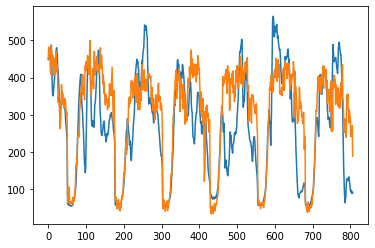

In [12]:
import matplotlib.pyplot as plt

plt.plot(model_pre[:, 0, 0])
plt.plot(label_test[:, 0, 0])

In [13]:
num_fold = len(next(iter(os.walk('../runs_base/stdnn/')))[1])  # number of existing folders
os.mkdir('../runs_base/stdnn/run%i'%(num_fold+1))

path = '../runs_base/stdnn/run'+str(num_fold+1)+'/'
# save model
finish_model.save_weights(path+'base_ST-DTNN_%s_mape=%.5f_nrmse=%.5f.h5'%(class_color_set[class_i], mape, nrmse))

# save data
result = pd.DataFrame([[mape, smape, nrmse, mae]], columns=['mape', 'smape', 'nrmse', 'mae'], index=['value'])
result.to_csv(path+'res.csv')

# save predicted flow
# np.load('../runs_base/fc/run1/val_pre.npy').shape
np.save(file=path+'val_pre.npy', arr=model_pre)

# save ground truth flow
np.save(file=path+'val_g_t.npy', arr=label_test)

# save hyper parameters
hyper = pd.DataFrame([[m, res, prop, randseed, t_pre, label_train.shape[0], label_test.shape[0], label_test.shape[1]]], \
                     columns=['mask', 'res', 'prop', 'randseed', 'pred_samp', 'train data samples', 'val data samples', 'num detectors'], index=['value'])
hyper.to_csv(path+'hyper.csv')

# save loss sets
# np.savetxt(path+'val_loss.csv', np.array(val_loss_set), delimiter=',')
# np.savetxt(path+'train_loss.csv', np.array(train_loss_set), delimiter=',')